# Can we find zero in less than 20 iterations ?
## The Quest for the Ultimate Optimizer - Episode 2
-------------------------------------------------------------------

This notebook is a continuation of the [first episode of my Quest for the Ultimate Optimizer series of notebooks](https://github.com/Ericvulpi/The-Quest-for-the-Ultimate-Optimizer/blob/master/Episode1/Episode1.ipynb), which was inspired by DeepMind’s paper [“Learning to learn by gradient descent by gradient descent”](https://arxiv.org/abs/1606.04474) and [Llion Jones's article on this paper](https://hackernoon.com/learning-to-learn-by-gradient-descent-by-gradient-descent-4da2273d64f2). I encourage you to read these if you want to understand how the following is set-up.

Being a continuation of the first episode, it contains quite a lot of setting-up that comes directly from it, and that I have positionned at the end to avoid repeating myself too much. This means that:
1. If you want to run this notebook, you need to start by running the appendix at the end before the rest of the notebook
2. If you haven't read the first notebook yet, go check it out, this one will make more sense if you start there.

### Appendix

I'll start with the same disclaimer as in the first notebook : the code in this section draws heavily from [Llion Jones's article](https://hackernoon.com/learning-to-learn-by-gradient-descent-by-gradient-descent-4da2273d64f2).  
I encourage you to read, it if you want to understand how it is set-up.
For the rest you'll find a bit more explanations in the first notebook.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os

In [2]:
# If you have tensorflow for GPU but want to use your CPU
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]=""

In [3]:
DIMS = 2  # Dimensions of the quadratic function, the simplest application problem in DeepMind's paper
scale = tf.random_uniform([DIMS], 0.5, 1.5)
# The scale vector gives a different shape to the quadratic function at each initialization 
def quadratic(x):
  x = scale*x
  return tf.reduce_sum(tf.square(x))

In [4]:
# Some reference optimizers for benchmarking

def g_sgd(gradients, state, learning_rate=0.1):
  # Vanilla Stochastic Gradient Descent
  return -learning_rate*gradients, state

def g_rms(gradients, state, learning_rate=0.1, decay_rate=0.99):
  # RMSProp (https://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf)
  if state is None:
    state = tf.zeros(DIMS)
  state = decay_rate*state + (1-decay_rate)*tf.pow(gradients, 2)
  update = -learning_rate*gradients / (tf.sqrt(state)+1e-5)
  return update, state

In [5]:
TRAINING_STEPS = 20  # This is 100 in the paper

initial_pos = tf.random_uniform([DIMS], -1., 1.)

def learn(optimizer):
  losses = []
  x = initial_pos
  state = None
  # The loop below unrolls the 20 steps of the optimizer into a single tensorflow graph
  for _ in range(TRAINING_STEPS):
    loss = quadratic(x)
    losses.append(loss)
    grads, = tf.gradients(loss, x)
    update, state = optimizer(grads, state)
    x += update
  return losses

In [6]:
sgd_losses = learn(g_sgd)
rms_losses = learn(g_rms)

In [7]:
# Now let's define the RNN optimizer
LAYERS = 2
STATE_SIZE = 20

cell = tf.contrib.rnn.MultiRNNCell(
  [tf.contrib.rnn.LSTMCell(STATE_SIZE) for _ in range(LAYERS)])
cell = tf.contrib.rnn.InputProjectionWrapper(cell, STATE_SIZE)
cell = tf.contrib.rnn.OutputProjectionWrapper(cell, 1)
cell = tf.make_template('cell', cell)

In [8]:
def optimize(loss, learning_rate=0.1):
  # "Meta optimizer" to be applied on the RNN defined above
  optimizer = tf.train.AdamOptimizer(learning_rate)
  gradients, v = zip(*optimizer.compute_gradients(loss))
  gradients, _ = tf.clip_by_global_norm(gradients, 1.)
  return optimizer.apply_gradients(zip(gradients, v))

In [9]:
def print_dict(*args):
  # Prints variables in a dict format for easier reading
  dict_name = dict((name,eval(name)) for name in args)
  print(dict_name)

In [10]:
def graph_optimizers(f1, f2, f3, it=3, training_steps=TRAINING_STEPS):
  # Graph to compare RNN to the 2 baseline optimizers
  x = np.arange(training_steps)
  for _ in range(it): 
    sgd_l, rms_l, rnn_l = sess.run([f1, f2, f3])
    p1, = plt.semilogy(x, sgd_l, label='SGD')
    p2, = plt.semilogy(x, rms_l, label='RMSProp')
    p3, = plt.semilogy(x, rnn_l, label='RNN')
    plt.legend(handles=[p1, p2, p3])
    plt.title('Losses')
    plt.show()

In [11]:
def rolling_log_average(array, L):
  # Rolling average of the log of the array over a length of L
  rolling_av = np.array([])
  for i in range(array.size):
    rolling_av = np.append(rolling_av, 10**(np.log10(array[:i+1][-L:] + 1e-38).mean()))
  return rolling_av

In [12]:
import warnings
def draw_convergence(*args):
  """Draws the convergence of one or several meta optimizations
  transparent area is the raw results, the plain line is the 500 rolling 'log average'"""
  it = 0
  for f in args:
    it = max(eval(f).size, it)
  handles = []
  for f in args:
    flist = eval(f)[np.logical_not(np.isnan(eval(f)))] #removes NaN
    flist_rolling = rolling_log_average(flist, 500)
    flist_size = flist.size
    #matplotlib doesn't like graphs of different length so we fill the shorter graphs with None
    if flist_size < it:
      flist = np.append(flist, [None]*(it-flist_size))
      flist_rolling = np.append(flist_rolling, [None]*(it-flist_size))
    c1, = plt.semilogy(range(it), flist, alpha=0.3)
    c2, = plt.semilogy(range(it), flist_rolling, color=c1.get_color(), label=f)
    handles = handles + [c2]
  plt.legend(handles=handles)
  plt.title('End result of the optimizer')
  #matplotlib still doesn't like graphs of different length so we filter associated warnings
  warnings.filterwarnings("ignore",category =RuntimeWarning)
  plt.show()

In [13]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

### Recap of the previous episode

In the [first notebook](https://github.com/Ericvulpi/The-Quest-for-the-Ultimate-Optimizer/blob/master/Episode1/Episode1.ipynb), we reused [Llion Jones's implementation](https://hackernoon.com/learning-to-learn-by-gradient-descent-by-gradient-descent-4da2273d64f2) of [“Learning to learn by gradient descent by gradient descent”](https://arxiv.org/abs/1606.04474) which set-up a RNN (recurrent neural network) in tensorflow for use as an optimizer that works similarly to SGD or RMSProp, then unrolls 20 of its iterations (we'll call those the "base" iterations) within a single tensorflow graph so that we can iteratively  modify the parameters of the RNN to minimize the result, thus optimizing the RNN optimizer (we'll call those the "meta" iterations).

The target was to beat RMSProp performance on the most simple problem you can think of : find the zero of a 2 dimension quadratic function.  
To do that we tweaked a little bit the objective function to avoid the problem of vanishing gradient as the RNN gets better, finally settling on log of the RNN result as our objective function to minimize.
We also implemented what I will describe as a "liberal" interpretation of the preprocessing scheme for the RNN  proposed in DeepMind's paper, which is basically to also apply the log function on the gradients of the quadratic function before feeding the result as input of the RNN.

Let's re-run the last 2 RNNs proposed in the previous notebook.  

In [14]:
def g_rnn_log15(gradients, state):
  gradients = tf.expand_dims(gradients, axis=1)
  
  # Casting of gradients from [exp(-15), 1] to [0, 1] and [-1, -exp(-15)] to [-1, 0]
  min_log_gradient = -15 
  log_gradients = tf.log(tf.abs(gradients) + np.exp(min_log_gradient-5)) # residual added to avoid log(0)
  sign_gradients = tf.sign(gradients)
  trans_gradients = tf.multiply(sign_gradients,((log_gradients - min_log_gradient) / (- min_log_gradient)))

  if state is None:
      state = [[tf.zeros([DIMS, STATE_SIZE])] * 2] * LAYERS
  update, state = cell(trans_gradients, state)

  # Casting of output from [0, 1] to [exp(-15), 1]  and [-1, 0] to [-1, -exp(-15)]
  abs_update = tf.abs(update)
  sign_update = tf.sign(update)
  update = tf.multiply(sign_update, tf.exp(abs_update * (- min_log_gradient) + min_log_gradient))
  return tf.squeeze(update, axis=[1]), state

rnn_losses = learn(g_rnn_log15)
log_loss = tf.log(rnn_losses[-1])
apply_update = optimize(log_loss, learning_rate=0.0003)

sess.run(tf.global_variables_initializer())

list_result = np.array([])
for it in range(50001):
  errors, _ = sess.run([rnn_losses, apply_update])
  list_result = np.append(list_result, errors[-1])
  if it % 50000 == 0 :
    optim_result = '{:.2E}'.format(errors[-1])
    average_log_result = '{:.2f}'.format(np.log10(list_result[-5000:]).mean())
    print_dict('it', 'optim_result', 'average_log_result')
RNN_log15_end_log_res = list_result

{'it': 0, 'optim_result': '9.05E-01', 'average_log_result': '-0.04'}
{'it': 50000, 'optim_result': '1.51E-12', 'average_log_result': '-12.27'}


In [15]:
def g_rnn_log30(gradients, state):
  gradients = tf.expand_dims(gradients, axis=1)
  
  # Casting of gradients from [exp(-30), 1] to [0, 1] and [-1, -exp(-30)] to [-1, 0]
  min_log_gradient = -30 
  log_gradients = tf.log(tf.abs(gradients) + np.exp(min_log_gradient-5))
  sign_gradients = tf.sign(gradients)
  trans_gradients = tf.multiply(sign_gradients,((log_gradients - min_log_gradient) / (- min_log_gradient)))

  if state is None:
      state = [[tf.zeros([DIMS, STATE_SIZE])] * 2] * LAYERS
  update, state = cell(trans_gradients, state)

  # Casting of output from [0, 1] to [exp(-30), 1]  and [-1, 0] to [-1, -exp(-30)]
  abs_update = tf.abs(update)
  sign_update = tf.sign(update)
  update = tf.multiply(sign_update, tf.exp(abs_update * (- min_log_gradient) + min_log_gradient))
  return tf.squeeze(update, axis=[1]), state

rnn_losses = learn(g_rnn_log30)
log_loss = tf.log(rnn_losses[-1])
apply_update = optimize(log_loss, learning_rate=0.0003)

sess.run(tf.global_variables_initializer())

list_result = np.array([])
for it in range(100001):
  errors, _ = sess.run([rnn_losses, apply_update])
  list_result = np.append(list_result, errors[-1])
  if it % 50000 == 0 :
    optim_result = '{:.2E}'.format(errors[-1])
    average_log_result = '{:.2f}'.format(np.log10(list_result[-5000:]).mean())
    print_dict('it', 'optim_result', 'average_log_result')
RNN_log30_end_log_res = list_result

{'it': 0, 'optim_result': '8.67E-01', 'average_log_result': '-0.06'}
{'it': 50000, 'optim_result': '9.13E-25', 'average_log_result': '-20.22'}
{'it': 100000, 'optim_result': '2.50E-26', 'average_log_result': '-22.57'}


In [16]:
# Target_RMS represents the log average of the results provided by RMSProp optimzer. It was the target for the first episode.
list_rms_errors = np.array([])
for it in range(1000):
  sgd_errors, rms_errors = sess.run([sgd_losses, rms_losses])
  list_rms_errors = np.append(list_rms_errors, rms_errors[-1])
Target_RMS = np.full(100001, rolling_log_average(list_rms_errors, 1000)[-1])

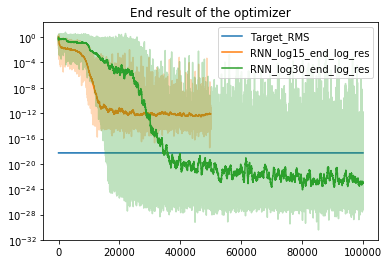

In [17]:
draw_convergence('Target_RMS', 'RNN_log15_end_log_res', 'RNN_log30_end_log_res')

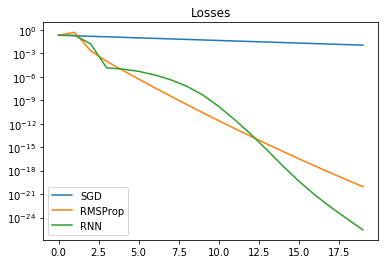

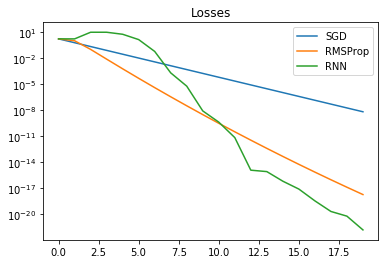

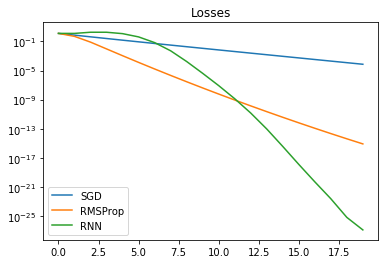

In [18]:
graph_optimizers(sgd_losses, rms_losses, rnn_losses)

We concluded the last episode by declaring victory over RMSProp ... but is it the best we can do ?

### How about actually finding 0 ?
To do that we need to define what is 0 in our context.  
It turns out Numpy offers an easy definition :

In [19]:
print(np.finfo(np.float32).tiny)

1.17549e-38


This is the zero machine, or more exactly the [machine epsilon](https://en.wikipedia.org/wiki/Machine_epsilon), which means values below (or rather below it's half) will be rounded to zero by the computer. Since our optimizers are looking for the lowest value of the quadratic function as calculated by the computer, what they are actually looking for is (more or less) to reach this value. Ideally, we should be able to tweak our RNN optimizer, so that it finds this value in less than 20 iterations.  
Now that we know what's our next target, let's give another look to the graph of convergences :

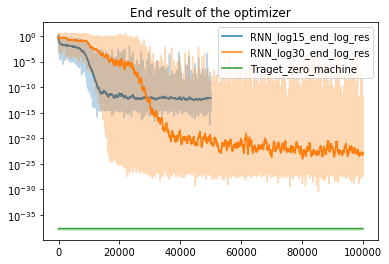

In [20]:
Traget_zero_machine = np.full(100001, np.finfo(np.float32).tiny)
draw_convergence('RNN_log15_end_log_res', 'RNN_log30_end_log_res', 'Traget_zero_machine')

The obvious way to improve our RNN_log optimizer would be to continue the trend and try RNN_log50, however we can already see that the RNN_log30 had hard time starting it's convergence, so it would be better if we could pinpoint what is the exact range of gradient we need to rescale to [-1, 1] in the preprocessing of our RNN to make it work from y = 1 to 1e-38.

To do that we should try to understand what defines the limit both RNN_log15 and RNN_log30 seem to hit (the horizontal "floor" of both the light blue and light orange area in the graph above).
Based on the rescaling of the log gradient we have defined, the RNN_log15 optimizer should stop working when the log gradient gets below -15

In [21]:
# What is the value of y when log(y') = -15, -30 ? y' respresents the derivative of y.
# y = x**2, y' = 2x, x = exp(log(y'))/2 so y = (exp(log(y'))/2)**2
print("For log(gradient) = -15, gradient : {:.1e}, y : {:.1e}".format(np.exp(-15), (np.exp(-15)/2)**2))
print("For log(gradient) = -30, gradient : {:.1e}, y : {:.1e}".format(np.exp(-30), (np.exp(-30)/2)**2))

For log(gradient) = -15, gradient : 3.1e-07, y : 2.3e-14
For log(gradient) = -30, gradient : 9.4e-14, y : 2.2e-27


Let's see how it looks

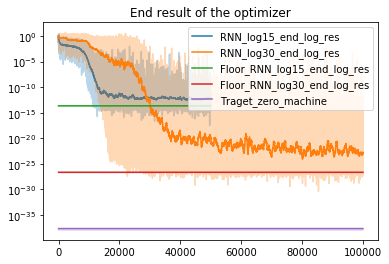

In [22]:
Floor_RNN_log15_end_log_res = np.full(50001, 2.3e-14)
Floor_RNN_log30_end_log_res = np.full(100001, 2.2e-27)
draw_convergence('RNN_log15_end_log_res', 'RNN_log30_end_log_res', 'Floor_RNN_log15_end_log_res', 'Floor_RNN_log30_end_log_res', 'Traget_zero_machine')

The horizontal lines I have added are both slightly above the minimum values reached by each RNN optimizers. That may be the result of the RNN behaving randomly once the limit is reached, with the RNN sometime hitting the bulls eye and getting a couple of additional orders of magnitudes below the limit, just because we are computing so many iterations.  
With that in mind, we could conclude that the floor that RNN_log15 is hitting (below y = 2e-14) corresponds to when the log(gradient) goes below -15.  
Same for RNN_log30 where the floor around 2e-27 corresponds to when the gradient reaches the limit of our preprocessing : -30.  

How about we calculate the optimal min_log_gradient for our next RNN trial :

In [23]:
# What's the log(gradient) when y = 1e-38 ?  y = x**2 so y' = 2x = 2*(y**0.5)
print("log_gradient for 1e-38 : ", np.log(2*(1e-38**0.5)))

log_gradient for 1e-38 :  -43.0559695863


In [24]:
def g_rnn_log43(gradients, state):
  gradients = tf.expand_dims(gradients, axis=1)
  
  # Casting of gradients from [exp(-43), 1] to [0, 1] and [-1, -exp(-43)] to [-1, 0]
  min_log_gradient = -43
  log_gradients = tf.log(tf.abs(gradients) + np.exp(min_log_gradient))
  sign_gradients = tf.sign(gradients)
  trans_gradients = tf.multiply(sign_gradients,((log_gradients - min_log_gradient) / (- min_log_gradient)))

  if state is None:
      state = [[tf.zeros([DIMS, STATE_SIZE])] * 2] * LAYERS
  update, state = cell(trans_gradients, state)

  # Casting of output from [0, 1] to [exp(-43), 1]  and [-1, 0] to [-1, -exp(-43)]
  abs_update = tf.abs(update)
  sign_update = tf.sign(update)
  update = tf.multiply(sign_update, tf.exp(abs_update * (- min_log_gradient) + min_log_gradient))
  return tf.squeeze(update, axis=[1]), state

rnn_losses = learn(g_rnn_log43)
log_loss = tf.log(rnn_losses[-1])
apply_update = optimize(log_loss, learning_rate=0.0003)

sess.run(tf.global_variables_initializer())

list_result = np.array([])
for it in range(50001):
  errors, _ = sess.run([rnn_losses, apply_update])
  list_result = np.append(list_result, errors[-1])
  if it % 5000 == 0 :
    optim_result = '{:.2E}'.format(errors[-1])
    average_log_result = '{:.2f}'.format(np.log10(list_result[-5000:]).mean())
    print_dict('it', 'optim_result', 'average_log_result')

# Let's store the convergence for later comparison
RNN_log43_end_log_res = list_result

{'it': 0, 'optim_result': '6.53E-02', 'average_log_result': '-1.18'}
{'it': 5000, 'optim_result': '1.09E+00', 'average_log_result': '-0.33'}
{'it': 10000, 'optim_result': '5.79E-01', 'average_log_result': '-0.34'}
{'it': 15000, 'optim_result': '5.91E-01', 'average_log_result': '-0.35'}
{'it': 20000, 'optim_result': '6.37E-02', 'average_log_result': '-0.33'}
{'it': 25000, 'optim_result': '9.07E-01', 'average_log_result': '-0.34'}
{'it': 30000, 'optim_result': '1.74E+00', 'average_log_result': '-0.33'}
{'it': 35000, 'optim_result': '1.75E-01', 'average_log_result': '-0.34'}
{'it': 40000, 'optim_result': '6.44E-01', 'average_log_result': '-0.33'}
{'it': 45000, 'optim_result': '5.72E-01', 'average_log_result': '-0.33'}
{'it': 50000, 'optim_result': '1.67E-01', 'average_log_result': '-0.33'}


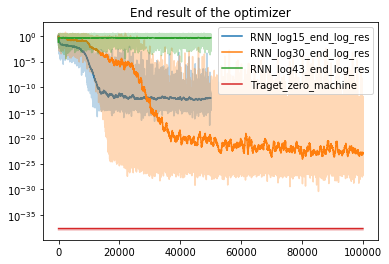

In [25]:
draw_convergence('RNN_log15_end_log_res', 'RNN_log30_end_log_res', 'RNN_log43_end_log_res', 'Traget_zero_machine')

RNN_log30 already had a hard time starting convengence, but RNN_log43 is just going nowhere.  
The way I see it : with the RNN_log30 rescaling, we were already squeezing 13 orders of magnitude of possible gradients (from 1 to 1e-13) into a small [-1, 1] bracket. This means that, at the start of the convergence, when the gradients are mainly between 1 and 0.1, the input to the RNN is going to vary between 1 and 0.92 (1-1/13=0.92) or between -1 and -0.92 for negative gradients, so clearly not the best situation for the RNN to make sense of things and find its optimum. Ideally you want your RNN inputs to spread evenly across the full [-1, 1] range.  
With RNN_log43, it looks like we went too far and squeezed too many orders of magnitude into the [-1, 1] bracket before the RNN had a chance to start converging.


#### Variable gradient casting
The approach proposed below adapts the gradient range during the optimization, gradually lowering the floor of log(gradients) as the RNN gets more precise. 

In [26]:
class Log_casting:
  ### Class used to cast logarithmically vectors from a variable range of scales below one to [-1, 1]
  
  def __init__(self, init):
    # scalar of the minimum log(gradient) encountered, initialized with init
    self.min_log_value = tf.Variable(float(init), name="min_log_value", trainable=False)
    # vector identity multiplied by min_log_value, initialized as None
    self.min_log = None
  
  def update_min_log(self, vector):
    # This method is called at each iteration of the meta optimizer to adapt the min_log_value based on the
    # last gradient (iteration 20) returned by the learn2 function (defined below)
    log_vector = tf.log(tf.abs(vector) + 1e-38)
    # update proposal based on the gradient, the factor 0.01 is to avoid confusing the RNN with a sudden big shift
    update_proposal = 0.01*tf.reduce_min(log_vector) + 0.99*self.min_log_value
    # the update is applied only if it is lower than the current value
    new_value = tf.assign(self.min_log_value, tf.minimum(update_proposal, self.min_log_value))
    return new_value
  
  def preprocess(self, gradients):
    # Casting of gradients from [exp(min_log_value), 1] to [0, 1] and [-1, -exp(min_log_value)] to [-1, 0]
    self.min_log = tf.ones_like(gradients, name='MIN_LOG')*self.min_log_value
    log_gradients = tf.log(tf.abs(gradients) + 1e-38)
    sign_gradients = tf.sign(gradients)
    inputs = tf.multiply(sign_gradients,((log_gradients - self.min_log) / (- self.min_log)))
    return inputs
  
  def postprocess(self, outputs):
    # Casting back RNN output from [0, 1] to [exp(min_log_value), 1] and [-1, 0] to [-1, -exp(min_log_value)] 
    self.min_log = tf.ones_like(outputs, name='MIN_LOG')*self.min_log_value
    abs_outputs = tf.abs(outputs)
    sign_outputs = tf.sign(outputs)
    update = tf.multiply(sign_outputs, tf.exp(abs_outputs * (- self.min_log) + self.min_log))
    return update

def learn2(optimizer):
  losses = []
  x = initial_pos
  state = None
  for _ in range(TRAINING_STEPS):
    loss = quadratic(x)
    losses.append(loss)
    grads, = tf.gradients(loss, x)
    update, state = optimizer(grads, state)
    x += update
  return losses, grads # the last gradient is added to the ouptut for use by Log_casting

In [27]:
Log_casting_ = Log_casting(-5) # initializes our "log caster" with a small range of 5 orders of magnitude

def g_rnn_logv(gradients, state):
  gradients = tf.expand_dims(gradients, axis=1)
  if state is None:
    state = [[tf.zeros([DIMS, STATE_SIZE])] * 2] * LAYERS
  
  inputs = Log_casting_.preprocess(gradients)
  outputs, state = cell(inputs, state)
  update = Log_casting_.postprocess(outputs)
  
  return tf.squeeze(update, axis=[1]), state

rnn_losses, grads = learn2(g_rnn_logv) # grads output added for use by log_casting
log_loss = tf.log(rnn_losses[-1] + 1e-38) # residual added to prevent a log(0)... the price of success
apply_update = optimize(log_loss, learning_rate=0.0003)
# operation below added to gradually adapt the min_log value to the lowest gardient
update_log_casting = Log_casting_.update_min_log(grads)

sess.run(tf.global_variables_initializer())

list_result = np.array([])
list_sum_log_res = np.array([])
for it in range(50001):
  errors, _, min_log = sess.run([rnn_losses, apply_update, update_log_casting])
  list_result = np.append(list_result, errors[-1])
  list_sum_log_res = np.append(list_sum_log_res, np.log10(np.array(errors) + 1e-38).sum()/20)
  if it % 10000 == 0 :
    optim_result = '{:.2E}'.format(errors[-1])
    av_log_res = '{:.2f}'.format(np.log10(list_result[-10000:] + 1e-38).mean())
    av_sum_log_res = '{:.2f}'.format(list_sum_log_res.mean())
    min_log = '{:.2f}'.format(min_log)
    print_dict('it', 'optim_result', 'av_log_res', 'av_sum_log_res', 'min_log')

RNN_logv_end_log_res = list_result

{'it': 0, 'optim_result': '1.57E+00', 'av_log_res': '0.20', 'av_sum_log_res': '0.20', 'min_log': '-5.00'}
{'it': 10000, 'optim_result': '9.29E-19', 'av_log_res': '-7.64', 'av_sum_log_res': '-3.28', 'min_log': '-21.22'}
{'it': 20000, 'optim_result': '2.56E-21', 'av_log_res': '-17.15', 'av_sum_log_res': '-5.01', 'min_log': '-32.38'}
{'it': 30000, 'optim_result': '5.95E-25', 'av_log_res': '-19.26', 'av_sum_log_res': '-5.77', 'min_log': '-37.09'}
{'it': 40000, 'optim_result': '2.27E-25', 'av_log_res': '-20.57', 'av_sum_log_res': '-6.27', 'min_log': '-40.11'}
{'it': 50000, 'optim_result': '5.45E-31', 'av_log_res': '-21.21', 'av_sum_log_res': '-6.61', 'min_log': '-42.03'}


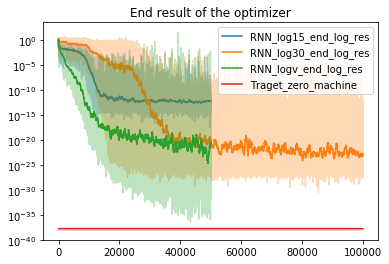

In [28]:
draw_convergence('RNN_log15_end_log_res', 'RNN_log30_end_log_res', 'RNN_logv_end_log_res', 'Traget_zero_machine')

So, on the plus side, the convergence is initially faster. We also seem to have removed the barrier preventing the RNN going lower than 1e-28. This allows the average result to continue improving, albeit very slowly.  
On the minus side, well, we are still nowhere near 0 (i.e. 1e-38) on average.

Before exploring new RNN configurations, let's try one last trick : instead of minimizing the log of the last result, we can minimize the sum of log of results of all 20 iterations.  
In theory, minimizing the last result should also minimize all previous iterations results, as the back propagation of gradients goes through each iterations starting from the last up to the first, so this should not change the results much. However, SGD-like optimizer can behaves rather cahotically, meaning a small delta on the first iteration can result in a big and unpredictable difference 20 iterations later. So, I'm not sure how far up the iterations chain we can back propagate gradients without losing "meaning" (i.e. improvement to the RNN that would generalize to another initialization). Anyway, if this back propagation ofgradients through iterations is an issue, adding all the iterations directly into the loss function will take care of it.  
An other benefit of this approach is that, if we ever want to reliably get to the "zero machine" within 20 iterations, we need to use a loss function that still gets smaller after the target is reached, which is what this approach does.

Enough talk, let's give it a go.

In [29]:
def optimize(loss, learning_rate=0.1):
  # "Meta optimizer" to be applied on the RNN defined above
  optimizer = tf.train.AdamOptimizer(learning_rate)
  gradients, v = zip(*optimizer.compute_gradients(loss))
  clipped_gradients, _ = tf.clip_by_global_norm(gradients, 1.)
  checked_gradients = []
  # The following loop is to remove any NaNs from the gradient as it would be introduced
  # in the RNN weights and everything would stop working
  for g in clipped_gradients:
    checked_g = tf.where(tf.is_nan(g), tf.zeros_like(g), g)
    checked_gradients = checked_gradients + [checked_g]
  return optimizer.apply_gradients(zip(checked_gradients, v))

In [30]:
rnn_losses, grads = learn2(g_rnn_logv)
sum_log_losses = tf.reduce_sum(tf.log(tf.add(rnn_losses, 1e-38))) #
apply_update = optimize(sum_log_losses, learning_rate=0.0003)
update_log_casting = Log_casting_.update_min_log(grads)

sess.run(tf.global_variables_initializer())

list_result = np.array([])
list_sum_log_res = np.array([])
for it in range(100001):
  errors, _, min_log = sess.run([rnn_losses, apply_update, update_log_casting])
  list_result = np.append(list_result, errors[-1])
  list_sum_log_res = np.append(list_sum_log_res, np.log10(np.array(errors) + 1e-38).sum()/20)
  if it % 10000 == 0 :
    optim_result = '{:.2E}'.format(errors[-1])
    av_log_res = '{:.2f}'.format(np.log10(list_result[-10000:] + 1e-38).mean())
    av_sum_log_res = '{:.2f}'.format(list_sum_log_res.mean())
    min_log = '{:.2f}'.format(min_log)
    print_dict('it', 'optim_result', 'av_log_res', 'av_sum_log_res', 'min_log')

RNN_logv_sum_log_res = list_result

{'it': 0, 'optim_result': '4.68E-01', 'av_log_res': '-0.33', 'av_sum_log_res': '-0.37', 'min_log': '-5.00'}
{'it': 10000, 'optim_result': '1.67E-14', 'av_log_res': '-8.56', 'av_sum_log_res': '-3.97', 'min_log': '-21.28'}
{'it': 20000, 'optim_result': '4.14E-18', 'av_log_res': '-18.66', 'av_sum_log_res': '-6.04', 'min_log': '-33.63'}
{'it': 30000, 'optim_result': '1.48E-24', 'av_log_res': '-23.33', 'av_sum_log_res': '-7.33', 'min_log': '-38.54'}
{'it': 40000, 'optim_result': '1.27E-26', 'av_log_res': '-23.73', 'av_sum_log_res': '-7.96', 'min_log': '-40.86'}
{'it': 50000, 'optim_result': '3.85E-18', 'av_log_res': '-24.25', 'av_sum_log_res': '-8.39', 'min_log': '-42.60'}
{'it': 60000, 'optim_result': '1.52E-31', 'av_log_res': '-24.92', 'av_sum_log_res': '-8.70', 'min_log': '-44.41'}
{'it': 70000, 'optim_result': '1.33E-30', 'av_log_res': '-24.99', 'av_sum_log_res': '-8.92', 'min_log': '-45.86'}
{'it': 80000, 'optim_result': '2.14E-33', 'av_log_res': '-25.80', 'av_sum_log_res': '-9.14', 'm

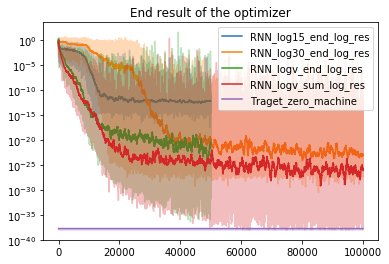

In [31]:
draw_convergence('RNN_log15_end_log_res', 'RNN_log30_end_log_res', 'RNN_logv_end_log_res',
                 'RNN_logv_sum_log_res', 'Traget_zero_machine')

This bring another improvement in terms of average end result.  
We also seem to have some cases where the optimizers does find the "zero machine" : where the light red area reaches the purple horizontal line. So we are definitely getting closer ... 

Let's have a look at what 3 tries of "base" convergence look like.

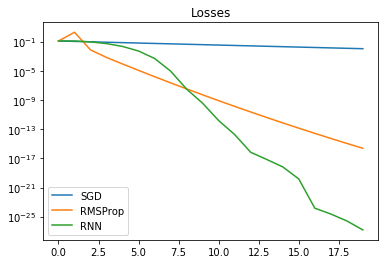

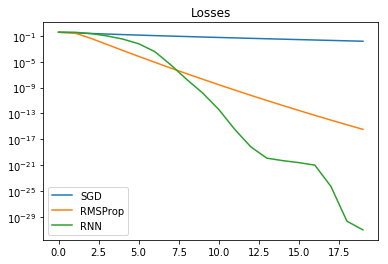

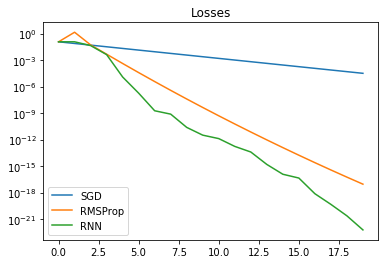

In [32]:
graph_optimizers(sgd_losses, rms_losses, rnn_losses)

This is a reminder that, although we have managed to remove the floor that prevented the RNN optimizer to reach the zero machine (1e-38), the average end result is still around 1e-23 ... far from our goal of 1e-38


#### Scale Invariant RNN
The first problem we highlighted is that we are trying to design a RNN that works as well at y=1 as at y=1e-38, with gradient varying between 1 and exp(-43)≈1e-19 (I should mention that this python confusing convention of writting small numbers like 10-5 with 1e-5 is most unfortunate in our context).  
The different implementations of logaritmic preprocessing of the gradients proposed above sort of address the problem by rescaling this huge variation of scale into a linear segment between 0 and 1 so that it is more or less interpretable by the RNN, but it's never truly scale invariant.  
There is probably a much better implementation of this idea of logaritmic preprocessing, but instead of sinking more time into fine tuning this (or digging into Deepmind's code to see how they cracked this :-), we can try a simpler approach : since the RNN is being fed the past 20 inputs, why not feed it only the ratios of gradients between one step and the next and let it make sense of it all. The information provided should be equivalent and it has the big benefit of being completely scale invarient.
It's actually one of the first ideas I tried. However, I was using the direct result of the RNN as the function to be minimized, and as we have seen, this leads to vanishing gradient if you're not applying log to the function result.

In [33]:
def g_rnn_div(gradients, state):
  gradients = tf.expand_dims(gradients, axis=1)
  if state is None:
    state_nn = [[tf.zeros([DIMS, STATE_SIZE])] * 2] * LAYERS
    state = [state_nn, gradients]
  inputs = tf.divide(gradients, tf.abs(state[1]) + 1e-38)
  update, state[0] = cell(inputs, state[0])
  outputs = tf.multiply(update, tf.abs(state[1]) + 1e-38)
  state[1] = gradients
  return tf.squeeze(outputs, axis=[1]), state

## With original "end_res" loss function
rnn_losses = learn(g_rnn_div)
end_loss = rnn_losses[-1]
apply_update = optimize(end_loss, learning_rate=0.0003)

sess.run(tf.global_variables_initializer())

list_result = np.array([])
list_sum_log_res = np.array([])
for it in range(50001):
  errors, _ = sess.run([rnn_losses, apply_update])
  list_result = np.append(list_result, errors[-1])
  list_sum_log_res = np.append(list_sum_log_res, np.log10(np.array(errors) + 1e-38).sum()/20)
  if it % 5000 == 0 :
    optim_result = '{:.2E}'.format(errors[-1])
    av_log_res = '{:.2f}'.format(np.log10(list_result[-5000:] + 1e-38).mean())
    av_sum_log_res = '{:.2f}'.format(list_sum_log_res.mean())
    print_dict('it', 'optim_result', 'av_log_res', 'av_sum_log_res')

RNN_div_end_res = list_result

{'it': 0, 'optim_result': '2.01E-01', 'av_log_res': '-0.70', 'av_sum_log_res': '-0.88'}
{'it': 5000, 'optim_result': '3.41E-06', 'av_log_res': '-4.90', 'av_sum_log_res': '-2.49'}
{'it': 10000, 'optim_result': '7.11E-09', 'av_log_res': '-6.76', 'av_sum_log_res': '-2.94'}
{'it': 15000, 'optim_result': '1.78E-08', 'av_log_res': '-7.38', 'av_sum_log_res': '-3.20'}
{'it': 20000, 'optim_result': '4.47E-09', 'av_log_res': '-8.11', 'av_sum_log_res': '-3.42'}
{'it': 25000, 'optim_result': '1.40E-11', 'av_log_res': '-8.81', 'av_sum_log_res': '-3.61'}
{'it': 30000, 'optim_result': '1.40E-08', 'av_log_res': '-9.48', 'av_sum_log_res': '-3.78'}
{'it': 35000, 'optim_result': '1.34E-10', 'av_log_res': '-9.75', 'av_sum_log_res': '-3.90'}
{'it': 40000, 'optim_result': '3.93E-09', 'av_log_res': '-9.15', 'av_sum_log_res': '-4.00'}
{'it': 45000, 'optim_result': '4.15E-13', 'av_log_res': '-9.07', 'av_sum_log_res': '-4.07'}
{'it': 50000, 'optim_result': '1.15E-10', 'av_log_res': '-8.47', 'av_sum_log_res': '-

In [34]:
## With "sum_log_res" loss function
rnn_losses = learn(g_rnn_div)
sum_log_losses = tf.reduce_sum(tf.log(tf.add(rnn_losses,1e-38)))
apply_update = optimize(sum_log_losses, learning_rate=0.0003)

sess.run(tf.global_variables_initializer())

list_result = np.array([])
list_sum_log_res = np.array([])
for it in range(100001):
  errors, _ = sess.run([rnn_losses, apply_update])
  list_result = np.append(list_result, errors[-1])
  list_sum_log_res = np.append(list_sum_log_res, np.log10(np.array(errors) + 1e-38).sum()/20)
  if it % 10000 == 0 :
    optim_result = '{:.2E}'.format(errors[-1])
    av_log_res = '{:.2f}'.format(np.log10(list_result[-10000:] + 1e-38).mean())
    av_sum_log_res = '{:.2f}'.format(list_sum_log_res.mean())
    print_dict('it', 'optim_result', 'av_log_res', 'av_sum_log_res')

RNN_div_sum_log_res = list_result

{'it': 0, 'optim_result': '6.11E-04', 'av_log_res': '-3.21', 'av_sum_log_res': '-2.27'}
{'it': 10000, 'optim_result': '6.14E-20', 'av_log_res': '-18.30', 'av_sum_log_res': '-8.50'}
{'it': 20000, 'optim_result': '1.64E-23', 'av_log_res': '-23.55', 'av_sum_log_res': '-9.90'}
{'it': 30000, 'optim_result': '7.30E-34', 'av_log_res': '-27.00', 'av_sum_log_res': '-10.88'}
{'it': 40000, 'optim_result': '0.00E+00', 'av_log_res': '-28.26', 'av_sum_log_res': '-11.50'}
{'it': 50000, 'optim_result': '9.17E-36', 'av_log_res': '-30.13', 'av_sum_log_res': '-12.07'}
{'it': 60000, 'optim_result': '6.09E-28', 'av_log_res': '-30.30', 'av_sum_log_res': '-12.44'}
{'it': 70000, 'optim_result': '2.76E-34', 'av_log_res': '-30.35', 'av_sum_log_res': '-12.71'}
{'it': 80000, 'optim_result': '1.65E-36', 'av_log_res': '-31.08', 'av_sum_log_res': '-12.92'}
{'it': 90000, 'optim_result': '5.45E-27', 'av_log_res': '-31.56', 'av_sum_log_res': '-13.13'}
{'it': 100000, 'optim_result': '4.94E-35', 'av_log_res': '-32.38', '

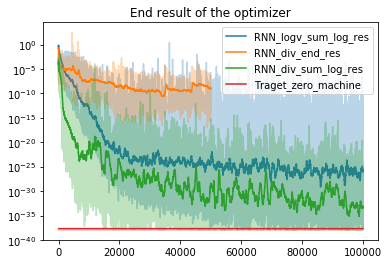

In [35]:
draw_convergence('RNN_logv_sum_log_res', 'RNN_div_end_res', 'RNN_div_sum_log_res', 'Traget_zero_machine')

So, with the "end_res" initial loss function I used, the convergence is initally fast but slows down quickly as the result improves and the corresponding gradients of the "meta" convergence goes to zero. Using the same loss function as for the RNN_logv optimizer, we get rid of the problem and finally get a big improvement : the end result log average is now below 1e-30 !

To be noted : the implementation above devides the gradient by the norm of the previous gradient. Dividing by the previous gradient, without the norm, yields more or less the same results.

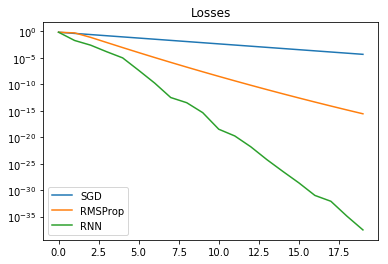

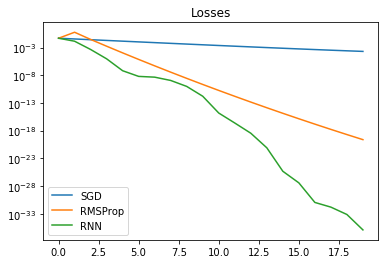

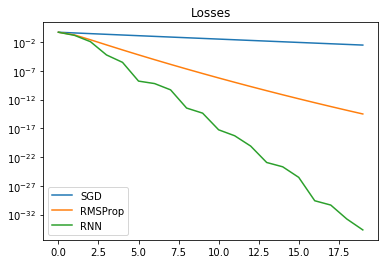

In [36]:
graph_optimizers(sgd_losses, rms_losses, rnn_losses)

Taking another look at the "base" convergence above reminds us that what we are trying to achieve - get through 38 orders of magnitude to find the zero machine within 20 iterations - is both pretty useless in terms of practical applications and pretty tricky as a theoretical exercise. It means we want the RNN to divide the "base" loss function by more than 100 every iteration, on average.  
Looking at the convergence of the RNN above, we can see that some iterations provide no gains, and some get through 4 orders of magnitude in one step. It means that, even if we feed into the RNN the ratio of gradients from one iteration to the next, we still get RNN input variations of 4 orders of magnitude (between 1e-4 and 1) which, as we have seen, is not ideal.

#### All-in
We already dealt with this problem with the log casting previously, so why not reuse the same solution and apply it on the ratio of gradient ? In other words, let's use every tricks we have used so far and see where we get.

In [37]:
def optimize(loss, learning_rate=0.1):
  # "Meta optimizer" to be applied on the RNN defined above
  optimizer = tf.train.AdamOptimizer(learning_rate)
  gradients, v = zip(*optimizer.compute_gradients(loss))
  clipped_gradients, _ = tf.clip_by_global_norm(gradients, 1.)
  checked_gradients = []
  for g in clipped_gradients:
    checked_g = tf.where(tf.is_nan(g), tf.zeros_like(g), g)
    checked_gradients = checked_gradients + [checked_g]
  return optimizer.apply_gradients(zip(checked_gradients, v))

In [38]:
Log_casting_ = Log_casting(-5)

def g_rnn_logdiv(gradients, state):
  gradients = tf.expand_dims(gradients, axis=1)
  if state is None:
    state_nn = [[tf.zeros([DIMS, STATE_SIZE])] * 2] * LAYERS
    state = [state_nn, gradients, gradients]
  inputs_ = tf.divide(gradients, tf.abs(state[1]) + 1e-38)
  inputs = Log_casting_.preprocess(inputs_)
  outputs, state[0] = cell(inputs, state[0])
  outputs_ = Log_casting_.postprocess(outputs)
  update = tf.multiply(outputs_, tf.abs(state[1]) + 1e-38)
  state[1] = gradients
  state[2] = inputs_
  return tf.squeeze(update, axis=[1]), state

def learn3(optimizer):
  losses = []
  x = initial_pos
  state = None
  for _ in range(TRAINING_STEPS):
    loss = quadratic(x)
    losses.append(loss)
    grads, = tf.gradients(loss, x)
    update, state = optimizer(grads, state)
    x += update
  return losses, state[2] # the last RNN input is added to the ouptut for use by Log_casting

rnn_losses, RNN_inputs = learn3(g_rnn_logdiv) # grads output added for use by log_casting
sum_log_losses = tf.reduce_sum(tf.log(tf.add(rnn_losses,1e-38)))
apply_update = optimize(sum_log_losses, learning_rate=0.0003)
# the operation below gradually adapts the min_log value to the lowest gardient ratio
update_log_casting = Log_casting_.update_min_log(RNN_inputs)

sess.run(tf.global_variables_initializer())

list_result = np.array([])
list_sum_log_res = np.array([])
for it in range(100001):
  errors, _, min_log = sess.run([rnn_losses, apply_update, update_log_casting])
  list_result = np.append(list_result, errors[-1])
  list_sum_log_res = np.append(list_sum_log_res, np.log10(np.array(errors) + 1e-38).sum()/20)
  if it % 10000 == 0 :
    list_result_ = list_result[~np.isnan(list_result)]
    list_sum_log_res_ = list_sum_log_res[~np.isnan(list_sum_log_res)]
    NaN = list_result.size - list_result_.size
    optim_result = '{:.2E}'.format(errors[-1])
    av_log_res = '{:.2f}'.format(np.log10(list_result[-10000:] + 1e-38).mean())
    av_sum_log_res = '{:.2f}'.format(list_sum_log_res.mean())
    min_log = '{:.2f}'.format(min_log)
    print_dict('it', 'optim_result', 'av_log_res', 'av_sum_log_res', 'min_log', 'NaN')

RNN_logdiv_sum_log_res = list_result

{'it': 0, 'optim_result': '2.88E+00', 'av_log_res': '0.46', 'av_sum_log_res': '0.29', 'min_log': '-5.00', 'NaN': 0}
{'it': 10000, 'optim_result': '1.55E-23', 'av_log_res': '-15.72', 'av_sum_log_res': '-7.28', 'min_log': '-5.94', 'NaN': 0}
{'it': 20000, 'optim_result': '1.13E-34', 'av_log_res': '-26.11', 'av_sum_log_res': '-9.60', 'min_log': '-6.91', 'NaN': 0}
{'it': 30000, 'optim_result': '2.33E-37', 'av_log_res': '-33.07', 'av_sum_log_res': '-11.62', 'min_log': '-7.73', 'NaN': 0}
{'it': 40000, 'optim_result': '0.00E+00', 'av_log_res': '-36.61', 'av_sum_log_res': '-13.22', 'min_log': '-8.19', 'NaN': 0}
{'it': 50000, 'optim_result': '0.00E+00', 'av_log_res': '-37.25', 'av_sum_log_res': '-14.27', 'min_log': '-8.46', 'NaN': 0}
{'it': 60000, 'optim_result': '0.00E+00', 'av_log_res': '-37.51', 'av_sum_log_res': '-15.01', 'min_log': '-8.91', 'NaN': 0}
{'it': 70000, 'optim_result': '0.00E+00', 'av_log_res': '-37.62', 'av_sum_log_res': '-15.55', 'min_log': '-9.11', 'NaN': 0}
{'it': 80000, 'opt

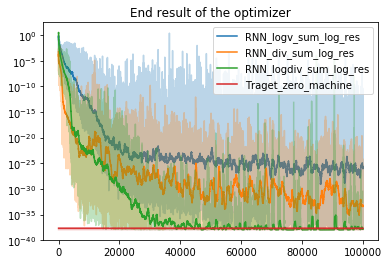

In [39]:
draw_convergence('RNN_logv_sum_log_res', 'RNN_div_sum_log_res', 'RNN_logdiv_sum_log_res', 'Traget_zero_machine')

Haha!
That looks like victory !
Let's take a look at the "base" convergence.

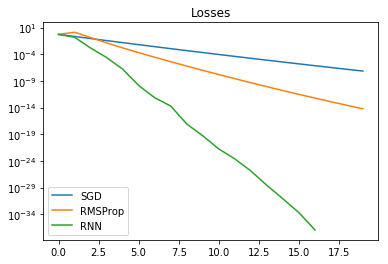

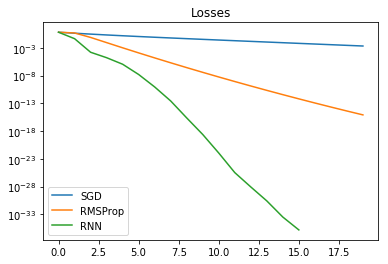

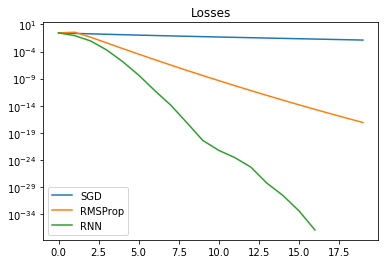

In [40]:
graph_optimizers(sgd_losses, rms_losses, rnn_losses)

Zero machine found in less than 20 iterations 3 times in a row ... I guess we can declare episode 2's target reached.

Quick recap of the few additional tricks we have used in this episode :
- we introduced a variable logarithmic rescaling on the input of the RNN “base” optimizer to both kick off the "meta" convergence with a small initial rescaling, then allow it reach the sero machine by gradually expanding the rescaling as necessary
- we changed the cost function to the sum of the logarithm of all 20 iterations. This allows the 
- we then tried another approach, using the ratio of gradient from one iteration to the next, as the input for the RNN
- we finally combined those 2 approaches to get an RNN capable of finding the "zero machine" of a quadratic function within 20 iterations

### What’s next ?

I mentionned in the previous episode that comparing a fine tuned RNN optimizer to SGD and RMSProp without at least playing a litle bit with their parameters is kind of unfair, so that's still on the agenda for episode 3.  
As i mentionned before, finding the zero machine of a quadratic function may be an interesting theoretical exercise, but it is pretty useless in terms of practical applications. So, another aspect I want to investigate is whether we can train those RNN optimizers on more complex functions, like the [Rosenbrock function](https://en.wikipedia.org/wiki/Rosenbrock_function) which is much trickier with its non-convex shape displaying a sort of long, narrow and curvy valley that is usually the death of SGD-like optimizers. I'd also like to check out if the RNN optimizer performance, once trained on such a complicated function, generalizes to a variety of other functions, or maybe train it simultaneously on a combination of different functions to enforce generalization.

Anyway, looks like this quest is not reaching its epilogue anytime soon.